In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/Seg

/content/drive/MyDrive/Seg


In [3]:
!ls

data.yaml	  Fire_model  runs		  test	 train	yolov8n.pt
Final_Code.ipynb  results     Segmentation.ipynb  test2  valid	yolov8n-seg.pt


In [4]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.12 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (AMD EPYC 7B12)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/107.7 GB disk)


In [5]:
from ultralytics import YOLO

from IPython.display import display, Image
from PIL import Image
import tensorflow as tf

import os
import matplotlib.pyplot as plt
import torch
import cv2



In [12]:
image_path = "test2/car2.png"

In [13]:
model = YOLO("runs/segment/train2/weights/best.pt")

In [14]:
fire_model = YOLO("/content/drive/MyDrive/Seg/Fire_model/weights/best.pt")

In [15]:
results = fire_model.predict(source=image_path,save=True,imgsz=256)

print(results[0].boxes)

# # Process results list
# for result in results:
#     boxes = result.boxes  # Boxes object for bounding box outputs
#     masks = result.masks  # Masks object for segmentation masks outputs
#     keypoints = result.keypoints  # Keypoints object for pose outputs
#     probs = result.probs  # Probs object for classification outputs
#     result.show()  # display to screen
#     # result.save(filename='result.jpg')  # save to disk


image 1/1 /content/drive/MyDrive/Seg/test2/car2.png: 256x256 1 fire, 219.0ms
Speed: 11.9ms preprocess, 219.0ms inference, 1992.5ms postprocess per image at shape (1, 3, 256, 256)
Results saved to runs/detect/predict25
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6915])
data: tensor([[163.1019, 266.8613, 259.9240, 360.2932,   0.6915,   0.0000]])
id: None
is_track: False
orig_shape: (519, 474)
shape: torch.Size([1, 6])
xywh: tensor([[211.5129, 313.5773,  96.8221,  93.4319]])
xywhn: tensor([[0.4462, 0.6042, 0.2043, 0.1800]])
xyxy: tensor([[163.1019, 266.8613, 259.9240, 360.2932]])
xyxyn: tensor([[0.3441, 0.5142, 0.5484, 0.6942]])


In [16]:
import os
import matplotlib.pyplot as plt

def show_images_in_folder(folder_path):
    # Get all files in the folder
    files = os.listdir(folder_path)
    image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    # Calculate the number of rows needed for the grid
    num_images = len(image_files)
    num_rows = (num_images + 1) // 2  # Round up if odd number of images
    num_cols = min(2, num_images)  # Ensure at most 2 columns

    # Create the grid of plots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows))

    # Display each image
    if num_images == 1:
        image_path = os.path.join(folder_path, image_files[0])
        image = plt.imread(image_path)
        axes.imshow(image)
        axes.axis('off')
        axes.set_title(image_files[0])
    else:
        for i, image_file in enumerate(image_files):
            row = i // 2
            col = i % 2
            image_path = os.path.join(folder_path, image_file)
            image = plt.imread(image_path)
            axes[row, col].imshow(image)
            axes[row, col].axis('off')
            axes[row, col].set_title(image_file)

    # Adjust layout
    plt.tight_layout()
    plt.show()


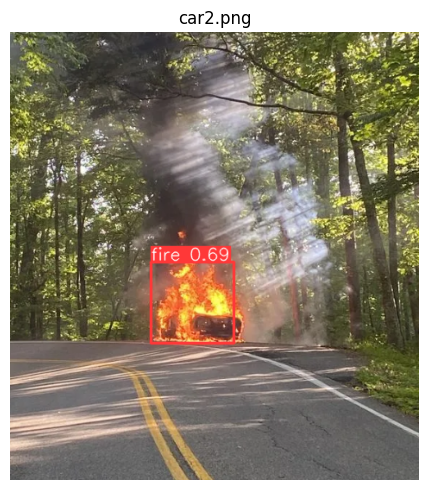

In [17]:
# Example usage: Provide the path to the folder containing images
folder_path = "runs/detect/predict25"
show_images_in_folder(folder_path)


In [18]:
# Given bounding box coordinates
xyxy = results[0].boxes.xyxy
print(xyxy)

tensor([[163.1019, 266.8613, 259.9240, 360.2932]])


In [19]:
# Calculate the coordinates of the encompassing bounding box
x_min = xyxy[:, 0].min()
y_min = xyxy[:, 1].min()
x_max = xyxy[:, 2].max()
y_max = xyxy[:, 3].max()

In [20]:
encompassing_bbox = [x_min, y_min, x_max, y_max]
print(encompassing_bbox)

[tensor(163.1019), tensor(266.8613), tensor(259.9240), tensor(360.2932)]


In [21]:
def tensor_to_array(tensor):
    if isinstance(tensor, list):
        return [t.item() for t in tensor]
    else:
        return tensor.item()

In [22]:
def superimpose_expanded_bbox(image_path, bbox_tensor):
    bbox = [tensor_to_array(coord) for coord in bbox_tensor]

    # Load the image
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape
    print("Image size: {} x {}".format(image_width, image_height))

    # Draw the expanded bounding box on the image
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 10)

    # Display the image with the expanded bounding box
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    plt.show()

Image size: 474 x 519


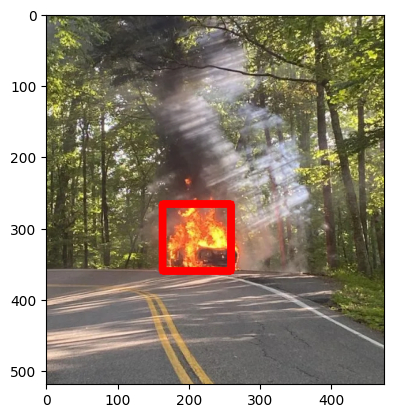

In [23]:
image_path = image_path
superimpose_expanded_bbox(image_path, encompassing_bbox)

In [24]:
def expand_bbox1(bbox, image_width, image_height, percentage):
    x_min, y_min, x_max, y_max = bbox
    extent_x = (x_max - x_min) * percentage / 100
    extent_y = (y_max - y_min) * percentage / 100
    x_min -= extent_x
    y_min -= extent_y
    x_max += extent_x
    y_max += extent_y
    # Ensure the expanded bounding box stays within the image boundaries
    x_min = max(10, x_min)
    # print(x_min)
    y_min = max(10, y_min)
    # print(y_min)
    x_max = min(image_width, x_max)
    y_max = min(image_height, y_max)
    return [x_min, y_min, x_max, y_max]

In [25]:
def superimpose_expanded_bbox1(image_path, bbox_tensor, percentage):
    bbox = [tensor_to_array(coord) for coord in bbox_tensor]

    # Load the image
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape
    print("Image size: {} x {}".format(image_width, image_height))

    bbox_expanded = expand_bbox1(bbox, image_width, image_height, percentage)

    # Draw the expanded bounding box on the image
    x_min, y_min, x_max, y_max = bbox_expanded
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 10)

    # Display the image with the expanded bounding box
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(bbox_expanded)

    return bbox_expanded

In [26]:
image_path = image_path

Image size: 474 x 519


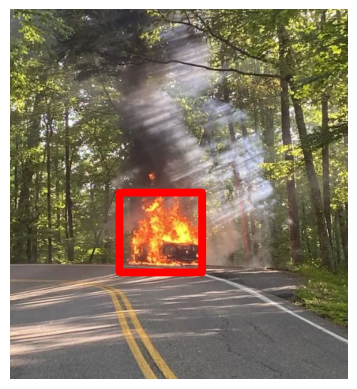

[153.41965942382814, 257.5181365966797, 269.6061584472656, 369.6364349365234]


In [31]:
# Percentage to expand the bounding box (you can adjust this value as needed)
percentage = 10

bounding_box_coords = superimpose_expanded_bbox1(image_path, encompassing_bbox, percentage)

In [32]:
def apply_second_model(image_path, bbox_expanded):
    print(bbox_expanded)
    # Load the image
    image = cv2.imread(image_path)

    # Crop the region defined by the expanded bounding box
    x_min, y_min, x_max, y_max = bbox_expanded
    cropped_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]

    results = model.predict(source=cropped_image, imgsz=640, save=True)

    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # plt.text(0, cropped_image.shape[0] + 20, "Vehicle Detected", color='green', fontsize=12, weight='bold')

    return results



[153.41965942382814, 257.5181365966797, 269.6061584472656, 369.6364349365234]

0: 640x640 1 Front-door, 218.7ms
Speed: 2.8ms preprocess, 218.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict21


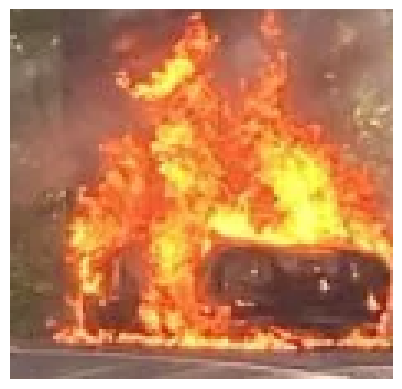

In [33]:
# Example usage
image_path = image_path  # Replace with the actual path to your image

# Call the function to apply the YOLO model on the cropped image
results = apply_second_model(image_path, bounding_box_coords)

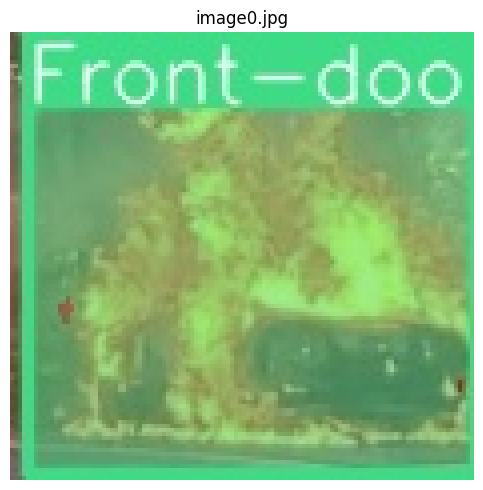

In [34]:
folder_path = "runs/segment/predict21"
show_images_in_folder(folder_path)

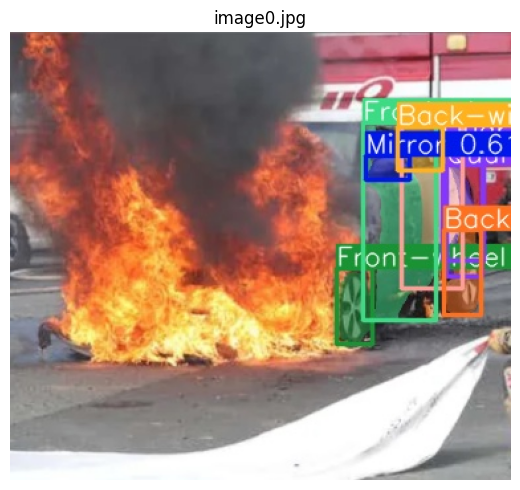

In [ ]:
folder_path = "runs/segment/predict17"
show_images_in_folder(folder_path)

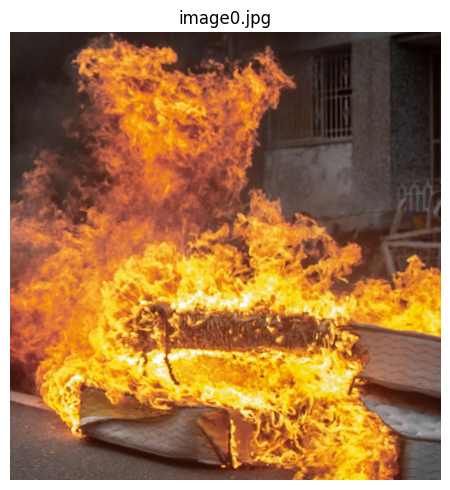

In [ ]:
folder_path = "runs/segment/predict16"
show_images_in_folder(folder_path)

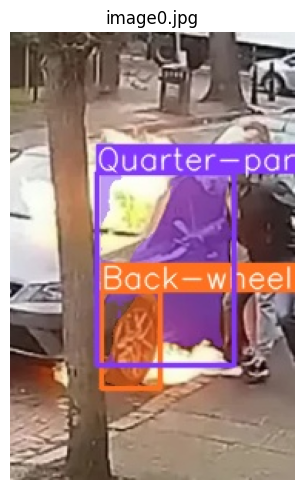

In [ ]:
folder_path = "runs/segment/predict15"
show_images_in_folder(folder_path)

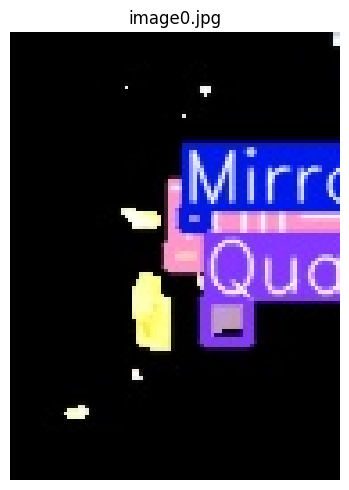

In [ ]:
folder_path = "runs/segment/predict14"
show_images_in_folder(folder_path)

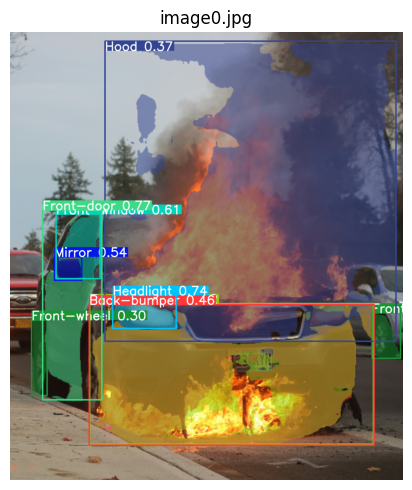

In [ ]:
folder_path = "runs/segment/predict13"
show_images_in_folder(folder_path)

In [ ]:
print(results)

In [ ]:
print(results[0].boxes)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 7., 11.,  9., 14.,  0., 12.,  6.,  8.,  8.])
conf: tensor([0.7701, 0.7414, 0.6059, 0.5371, 0.4623, 0.3746, 0.3193, 0.2980, 0.2872])
data: tensor([[2.9037e+02, 1.5856e+03, 8.1726e+02, 3.2755e+03, 7.7009e-01, 7.0000e+00],
        [9.1401e+02, 2.3443e+03, 1.4796e+03, 2.6407e+03, 7.4141e-01, 1.1000e+01],
        [4.1050e+02, 1.6222e+03, 8.0224e+02, 2.1961e+03, 6.0594e-01, 9.0000e+00],
        [3.9549e+02, 2.0012e+03, 6.3804e+02, 2.2112e+03, 5.3705e-01, 1.4000e+01],
        [7.0572e+02, 2.4277e+03, 3.2404e+03, 3.6796e+03, 4.6231e-01, 0.0000e+00],
        [8.4555e+02, 8.1595e+01, 3.4353e+03, 2.7544e+03, 3.7460e-01, 1.2000e+01],
        [7.0969e+02, 2.4188e+03, 3.2349e+03, 3.6712e+03, 3.1928e-01, 6.0000e+00],
        [1.9297e+02, 2.5657e+03, 3.3063e+02, 3.2374e+03, 2.9797e-01, 8.0000e+00],
        [3.2224e+03, 2.5016e+03, 3.4755e+03, 2.9066e+03, 2.8722e-01, 8.0000e+00]])
id: None
is_track: False
orig_shape: (3990, 3498)
s

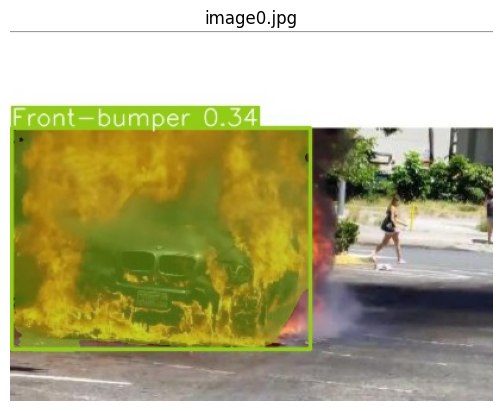

In [ ]:
folder_path = "runs/segment/predict12"
show_images_in_folder(folder_path)

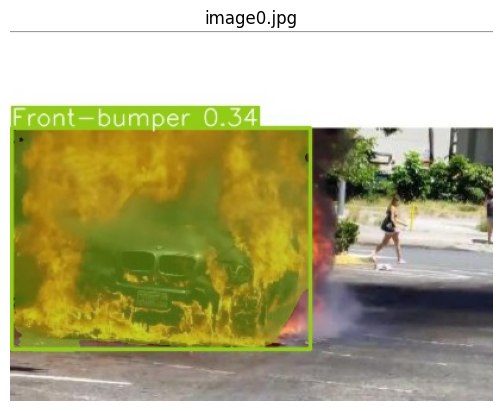

In [ ]:
folder_path = "runs/segment/predict9"
show_images_in_folder(folder_path)

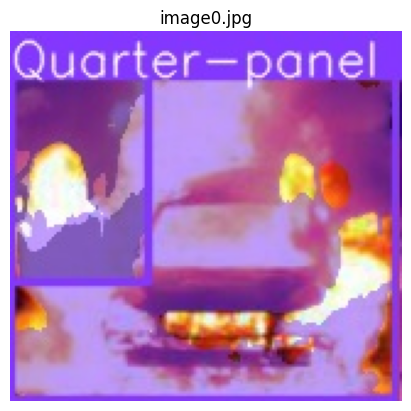

In [ ]:
folder_path = "runs/segment/predict8"
show_images_in_folder(folder_path)

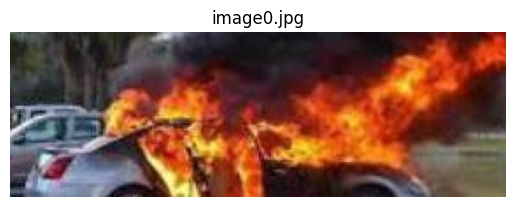

In [ ]:
folder_path = "runs/segment/predict7"
show_images_in_folder(folder_path)

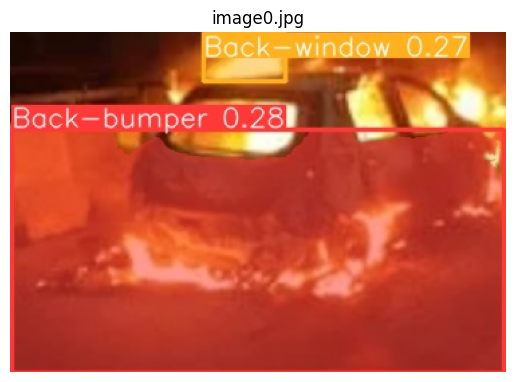

In [ ]:
folder_path = "runs/segment/predict5"
show_images_in_folder(folder_path)

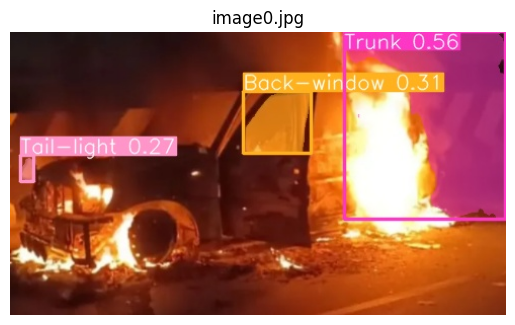

In [ ]:
folder_path = "runs/segment/predict2"
show_images_in_folder(folder_path)

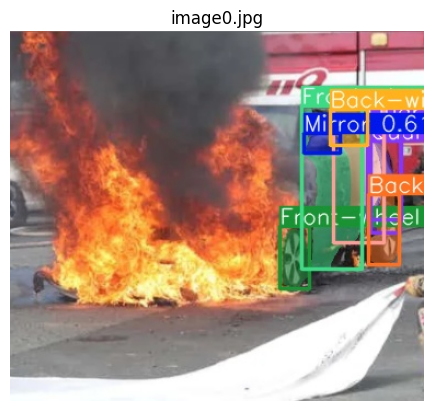

In [ ]:
folder_path = "runs/segment/predict10"
show_images_in_folder(folder_path)

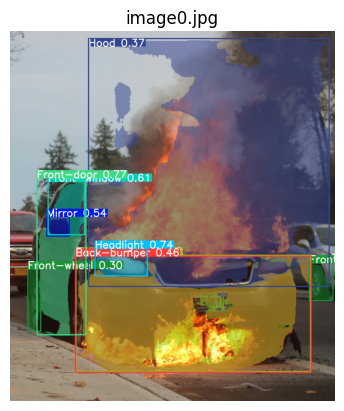

In [ ]:
folder_path = "runs/segment/predict6"
show_images_in_folder(folder_path)

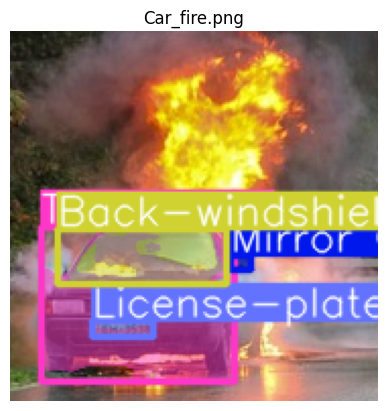

In [ ]:
folder_path = "runs/segment/predict"
show_images_in_folder(folder_path)

In [ ]:
folder_path = "results"
show_images_in_folder(folder_path)

Output hidden; open in https://colab.research.google.com to view.